In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt

Load the IMDB dataset from a CSV file into a Pandas DataFrame.

In [ ]:
data = pd.read_csv("/content/IMDB Dataset.csv")

Data Cleaning: Remove HTML tags from the 'review' column and check for missing values

In [ ]:
# Data Cleaning: Remove HTML tags from the 'review' column
def clean_text(text):
    # Remove HTML tags using BeautifulSoup
    text = BeautifulSoup(text, "html.parser").get_text()
    # Keep the text as it is without removing non-alphabetic characters
    return text
# Apply the cleaning function to the 'review' column
data['review'] = data['review'].apply(clean_text)


In [ ]:
# Check for missing or null values in the dataset
missing_values = data.isnull().sum()

# Display the number of missing values per column
print(missing_values)

# If you want a summary of only the columns that have missing values, you can filter them:
missing_values_filtered = missing_values[missing_values > 0]
print("Columns with missing values:")
print(missing_values_filtered)


review       0
sentiment    0
dtype: int64
Columns with missing values:
Series([], dtype: int64)


In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.shape

(50000, 2)

In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [ ]:
data["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


Replace the 'sentiment' column values: map 'positive' to 1 and 'negative' to 0 for binary classification.

In [ ]:
data.replace({"sentiment": {"positive": 1, "negative": 0}}, inplace=True)

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0
49999,No one expects the Star Trek movies to be high...,0


In [ ]:
data["sentiment"].value_counts()

,count
sentiment,
1,25000
0,25000


Import necessary libraries for data splitting, model creation, and data preprocessing.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Split the dataset into training and testing sets, using 20% of the data for testing.

In [ ]:
train_data, test_data = train_test_split(data, test_size = 0.2, random_state=42)

In [ ]:
train_data.shape

(40000, 2)

In [ ]:
test_data.shape

(10000, 2)

Initialize the tokenizer with a maximum vocabulary size of 5000 words, then fit it on the training data reviews.

In [ ]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_data["review"])

In [ ]:
# Convert the text reviews in the training and test datasets into sequences of integers,
# then pad these sequences to ensure they all have the same length of 200 for model input.
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data["review"]), maxlen=200)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data["review"]), maxlen=200)

In [ ]:
X_train

array([[   1,  726, 1934, ...,  204,  350, 3851],
       [  60,   25, 2111, ...,   88,  102,    8],
       [   0,    0,    0, ...,    2,  708,   61],
       ...,
       [   0,    0,    0, ..., 1639,    2,  603],
       [   0,    0,    0, ...,  244,  102,  124],
       [   0,    0,    0, ...,   69,   72, 2060]], dtype=int32)

In [ ]:
X_test

array([[   0,    0,    0, ...,  993,  721,  155],
       [   8,   57,   25, ...,   47,    9,  379],
       [   0,    0,    0, ...,   49, 1086,   96],
       ...,
       [   0,    0,    0, ...,  124,  199, 3249],
       [   0,    0,    0, ..., 1064,    1, 2304],
       [   0,    0,    0, ...,    1,  332,   26]], dtype=int32)

In [ ]:
# Extract the sentiment labels (positive/negative) from the training and test datasets
# to be used as targets for the model training and evaluation.
Y_train = train_data["sentiment"]
Y_test = test_data["sentiment"]

In [ ]:
Y_train

,sentiment
39087,0
30893,0
45278,1
16398,0
13653,0
...,...
11284,1
44732,1
38158,0
860,1


Build the LSTM Model

In [ ]:
model = Sequential()

# 1. Add an embedding layer:
#    - input_dim = 5000: Vocabulary size is 5000 words.
#    - output_dim = 128: Each word will be represented as a 128-dimensional vector.
#    - input_length = 200: Input sequences are padded to a length of 200.
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))

# 2. Add an LSTM layer with 128 units:
#    - dropout = 0.2: Regularization technique to prevent overfitting (dropout on input connections).
#    - recurrent_dropout = 0.2: Dropout on the recurrent connections.
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# 3. Add a Dense output layer with a sigmoid activation function:
#    - Output size = 1 (since it's binary classification).
#    - Sigmoid activation outputs a probability between 0 and 1 (used for binary classification).
model.add(Dense(1, activation="sigmoid"))

In [ ]:
# Compile the model for training
model.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model on the training dataset
history = model.fit(X_train, Y_train, epochs = 6, batch_size = 64, validation_split = 0.2)

Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 132s 251ms/step - accuracy: 0.7305 - loss: 0.5216 - val_accuracy: 0.8478 - val_loss: 0.3518
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 134s 244ms/step - accuracy: 0.8536 - loss: 0.3518 - val_accuracy: 0.8540 - val_loss: 0.3488
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 244ms/step - accuracy: 0.8578 - loss: 0.3389 - val_accuracy: 0.8568 - val_loss: 0.3514
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 246ms/step - accuracy: 0.8581 - loss: 0.3284 - val_accuracy: 0.8794 - val_loss: 0.2872
Epoch 5/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 247ms/step - accuracy: 0.9161 - loss: 0.2150 - val_accuracy: 0.8844 - val_loss: 0.2860
Epoch 6/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 246ms/step - accuracy: 0.9312 - loss: 0.1787 - val_accuracy: 0.8816 - val_loss: 0.3042


Model Summary

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, 200, 128)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (64, 128)                   │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,315,141 (8.83 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,543,428 (5.89 MB)

In [ ]:
# Save the trained model to a file in HDF5 format
model.save("model.h5")  # This allows for easy loading and reuse of the model later

In [ ]:
import joblib
# Save the tokenizer object to a file in pickle format
joblib.dump(tokenizer, "tokenizer.pkl")  # This allows for easy reuse of the tokenizer later in the model

['tokenizer.pkl']

In [ ]:
# Evaluate the trained model on the test dataset
loss, accuracy = model.evaluate(X_test, Y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8855 - loss: 0.2922


In [ ]:
print(loss)

0.2866192162036896


In [ ]:
print(accuracy)

0.8883000016212463


Accuracy Graph

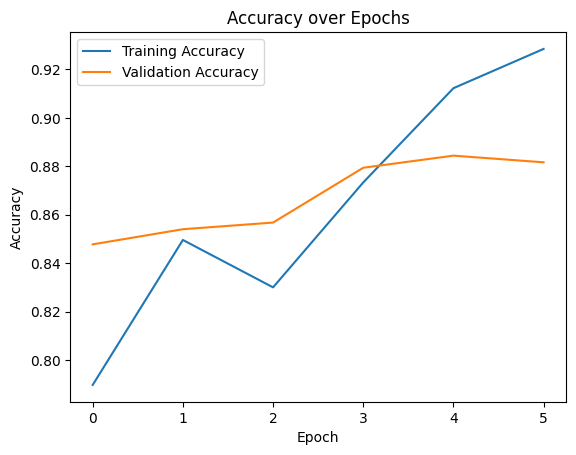

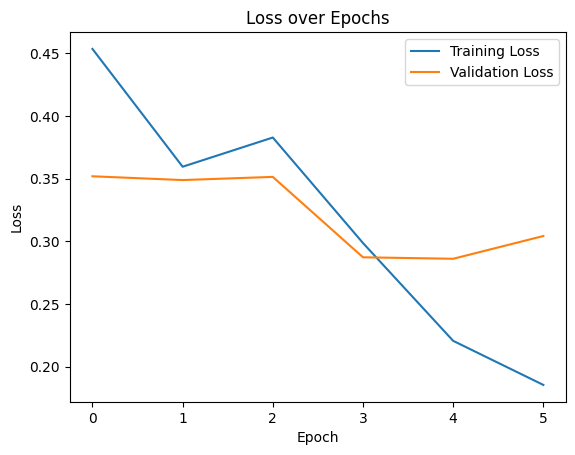

In [ ]:
# Function to plot training accuracy and loss
def plot_training_history(history):
    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function to plot the graphs
plot_training_history(history)

In [ ]:
# Building Predictive System

In [ ]:
def predictive_system(review):
  sequences = tokenizer.texts_to_sequences([review])
  padded_sequence = pad_sequences(sequences, maxlen=200)
  prediction = model.predict(padded_sequence)
  sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
  return sentiment

In [ ]:
predictive_system("A breathtaking journey that combines stunning visuals with a heartfelt story. A must-watch for everyone!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


'positive'

In [ ]:
predictive_system("Incredible performances and a gripping plot! This film kept me on the edge of my seat from start to finish.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


'positive'

In [ ]:
predictive_system("A delightful mix of humor and emotion. The characters felt real, and I couldn't help but root for them!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


'positive'

In [ ]:
predictive_system("Disappointing and predictable. The plot felt rushed, and the characters lacked depth, making it hard to care about their journey.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


'negative'